In [2]:
#!pip install tensorflow==2.9

In [3]:

# Milestone Project 2: ScimLit

# The purpose of this notebook is to build an NLP model to make reading medical absctracts easier
# The paper we are replicating (the source of datasets we will be using ) https://arxiv.org/abs/1710.06071

# And reading through the paper above, we see that the model architecture that they use to achieve their best results is
# available here : https://arxiv.org/abs/1612.05251

# lots of diagram is in the github https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


In [5]:
# datasets here https://github.com/Franck-Dernoncourt/pubmed-rct

import tensorflow as tf
tf.__version__

'2.9.0'

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [7]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# !ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [8]:
# Start our experiments using the 20k datasets with numbers replaced by the @



In [9]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [10]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [11]:
## Preprocess data

def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()





In [12]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]





['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [13]:
# [{'line_number': 0,
# 'target': 'BACKGROUND',
# 'text':'Emotional eating is associated with overeating and the development of obesity .\n' ,
# 'total_lines': 11}, ...]
import re

def preprocess_line_with_regex(line):
    match = re.match(r"(\w+)\s+(.*)", line)  # Dopasuj: pierwsze słowo, a potem resztę
    if match:
        return [match.group(1), match.group(2)]
    return [line.strip(), ""]




def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        if len(target_text_split) != 2:
          target_text_split = preprocess_line_with_regex(abstract_line)
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples






In [14]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")



len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [15]:
test_samples[:5]

[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ %

In [16]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [17]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

test_df.tail(14)

,target,text,line_number,total_lines
30121,BACKGROUND,there is a need to investigate varying exercis...,4,17
30122,METHODS,twenty-eight individuals from outpatient physi...,5,17
30123,METHODS,"apart from repetition volume , all other aspec...",6,17
30124,METHODS,tendinopathy clinical severity was assessed wi...,7,17
30125,METHODS,pain intensity was assessed using a visual ana...,8,17
30126,METHODS,"both were assessed at baseline , @ weeks , and...",9,17
30127,METHODS,treatment satisfaction was assessed at week @ .,10,17
30128,METHODS,adverse effects were also monitored .,11,17
30129,RESULTS,there was a statistically significant within-g...,12,17
30130,RESULTS,there was a statistically significant between-...,13,17


In [18]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


In [19]:
test_df.target.value_counts()

,count
target,
METHODS,9897
RESULTS,9713
CONCLUSIONS,4571
BACKGROUND,3621
OBJECTIVE,2333


<Axes: ylabel='Frequency'>

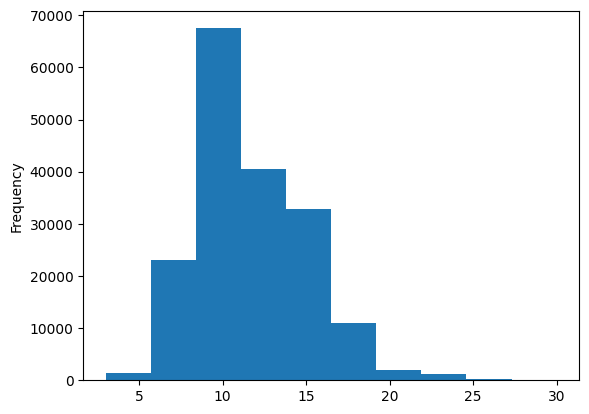

In [20]:
train_df.total_lines.plot.hist()

In [21]:
###

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [22]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [23]:
# Make numeric labels

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf


one_hot_encoder = OneHotEncoder(sparse_output=False)

import sklearn
print(sklearn.__version__)

1.5.2


In [24]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [25]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [26]:
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))


In [27]:
# Extract labels (target columns )
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())


train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [28]:
# Get class names and numbers of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [29]:
### base line model
# Model 0 :

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # Instantiate the TfidfVectorizer
    ("clf", MultinomialNB())
])

# Fit the model to your training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate

model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [31]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)

In [32]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [33]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [34]:
# Download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-12-09 07:41:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-12-09 07:41:31 (9.30 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [35]:
from helper_functions import calculate_results

In [36]:
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds

)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [37]:
# Model 1
## Conv 1D with token embeddings

import numpy as np
import tensorflow as tf
from tensorflow.keras  import layers

In [38]:
# How long is each sentence on average ?

sent_lens = [len(sentence.split()) for sentence in train_sentences]

avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

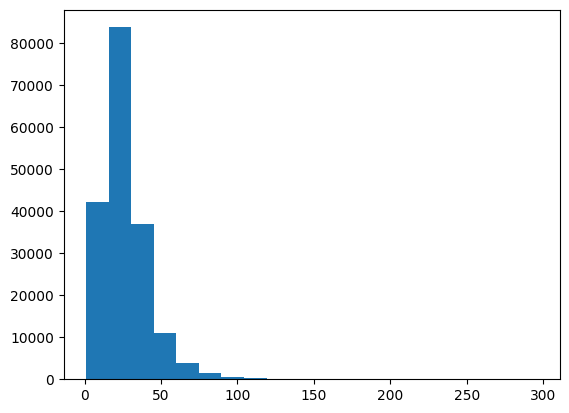

In [39]:
# What's the distribution look like ?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [40]:
# How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [41]:
# Maximum lenght

max(sent_lens)

296

In [42]:
### Create text vectorizer layer

# How many words are in our vocab ? (taken from table 2) https://arxiv.org/pdf/1710.06071.pdf

max_tokens = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences





In [43]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [44]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
single-blind , randomized controlled trial .

Length of text: 6

Vectorized text: [[1648   29  106   32    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [45]:
# How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab 64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [46]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [47]:
### Create custom text embedding

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of param of train
                               mask_zero=True, # use masking to handle variable sequence len()
                               name="token_embedding"
                               )

In [48]:
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentene shape: {embedded_sentence.shape}")

Sentence before vectorization:
 single-blind , randomized controlled trial .
Sentence after vectorization (before embedding):
 [[1648   29  106   32    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding: 
 [[[-0.01015208  0.00972205 -0.04157788 ...  0.01827863 -0.02724339
    0.04998964]
  [ 0.00131547 -0.02143835  0.04142125 ... -0.00179061  0.03277281
    0.01590029]
  [ 0.00867071  0.00387565  0.03731531 ...  0.0335786   0.01723083
   -0.04429689]
  ...
  [-0.03287693 -0.02306726 -0.02471462 ...  0.00635598  0.0319075
    0.04484632]
  [-0.03287693 -0.02306726 -0.02471462 ...  0.00635598  0.0319075
    0.04484632]
  [-0.03287693 -0.02306726 -0.02471462 ...  0.00635598  0.0319075
    0.04484632]]]

Embedded sentene shape: (1, 55, 128)


In [49]:
## Creating datasets (making sure our data loads as fast as possible)

# https://www.tensorflow.org/guide/data_performance
# https://www.tensorflow.org/guide/data

# Turn our data into TensorFlow Datesets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
# Take the TensorSliceDataset's and turn them into prefected datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [52]:
## Model 1: Conv1D with token embeddings

inputs = layers.Input(shape=(1,), dtype=tf.string) # one sequwnce at the time
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # 1 - dimesional sequences , condance the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])





In [53]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [54]:
# Fit the model

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only 10 % of batches

Epoch 1/3
562/562 [==============================] - 61s 108ms/step - loss: 0.9221 - accuracy: 0.6342 - val_loss: 0.6828 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 68s 122ms/step - loss: 0.6558 - accuracy: 0.7575 - val_loss: 0.6300 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 85s 151ms/step - loss: 0.6164 - accuracy: 0.7735 - val_loss: 0.5981 - val_accuracy: 0.7822


In [55]:
len(train_dataset)

5627

In [56]:
562 / 32

17.5625

In [57]:
5627 * 32 # samples

180064

In [58]:
# Evaluate on whole validation dateset

model_1.evaluate(valid_dataset)


945/945 [==============================] - 7s 7ms/step - loss: 0.5999 - accuracy: 0.7861


[0.5998612642288208, 0.7860783934593201]

In [59]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(array([[4.32142556e-01, 1.71886221e-01, 7.67313913e-02, 2.85994411e-01,
         3.32454704e-02],
        [4.94675457e-01, 2.13118076e-01, 1.55324480e-02, 2.70057976e-01,
         6.61593536e-03],
        [1.30650371e-01, 7.28196558e-03, 1.00711209e-03, 8.61043036e-01,
         1.74938323e-05],
        ...,
        [5.06537162e-06, 4.75118752e-04, 4.86704404e-04, 3.74998967e-06,
         9.99029398e-01],
        [5.84695190e-02, 4.57947940e-01, 1.12824865e-01, 6.46935403e-02,
         3.06064069e-01],
        [1.38866544e-01, 7.16073036e-01, 3.35519873e-02, 3.78546007e-02,
         7.36538321e-02]], dtype=float32),
 (30212, 5))

In [60]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [61]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.60783794518734,
 'precision': 0.7832513575779139,
 'recall': 0.7860783794518734,
 'f1': 0.7835383385487394}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [63]:
## Model 2: Feature extraction with pretrained token embeddings

# Now lets use pretrained word embeddings from Tensorflow Hub ,
# more specifu=ically the universal sentence encoder:

# https://tfhub.dev/google/universal-sentence-encoder/4

In [64]:
# The paper originally used GloVe embeddings, however , we are going
# to stick with the later created USE pretrained embeddings

# Download pretrained Tensorflow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [65]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}\n")






Random sentence:
 there was little or no association between patient 's perception of time to onset of effect and change in fev@ , or change in percent predicted fev@ .
Sentence after embedding:
 [ 0.04289254 -0.03042547 -0.08713496 -0.01692146 -0.07916109  0.06729838
  0.04806066 -0.03265832  0.03960377  0.06388887  0.05745989  0.05887251
  0.08042478  0.07840941  0.06023828 -0.03276446 -0.08442055 -0.08420962
 -0.00633039 -0.03399144  0.09084461  0.06068366 -0.00506021  0.0604432
 -0.03486846  0.04110066  0.05122816  0.00871544 -0.02582011 -0.00605283]

Length of sentence embedding: 512



In [66]:
## Model 2: BUilding and fitting an NLP feature extraction model using pretrained embeddings

inputs = layers.Input(shape=[], dtype=tf.string) # one sequwnce at the time
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text automatically and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])










In [67]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [68]:
# Fit the model

history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only 10 % of batches

Epoch 1/3
562/562 [==============================] - 18s 18ms/step - loss: 0.9170 - accuracy: 0.6466 - val_loss: 0.7984 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7697 - accuracy: 0.7016 - val_loss: 0.7563 - val_accuracy: 0.6995
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.7532 - accuracy: 0.7120 - val_loss: 0.7383 - val_accuracy: 0.7158


In [69]:
# Evaluate on whole validation dateset

model_2.evaluate(valid_dataset)



945/945 [==============================] - 18s 19ms/step - loss: 0.7406 - accuracy: 0.7134


[0.7405967712402344, 0.7133920192718506]

In [70]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 21s 22ms/step


(array([[4.6314618e-01, 3.4977424e-01, 2.7719012e-03, 1.7688204e-01,
         7.4255369e-03],
        [3.6344725e-01, 4.7869658e-01, 3.8829912e-03, 1.5130311e-01,
         2.6700262e-03],
        [2.2769569e-01, 1.4791241e-01, 2.0926917e-02, 5.6143278e-01,
         4.2032111e-02],
        ...,
        [1.8042612e-03, 5.5293906e-03, 5.2211091e-02, 7.6530088e-04,
         9.3968987e-01],
        [4.3712077e-03, 4.2940486e-02, 1.8113452e-01, 1.4229213e-03,
         7.7013093e-01],
        [1.7441499e-01, 2.4515592e-01, 4.9177158e-01, 7.4836109e-03,
         8.1173927e-02]], dtype=float32),
 (30212, 5))

In [71]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [72]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 71.33920296570899,
 'precision': 0.7130355237469834,
 'recall': 0.7133920296570899,
 'f1': 0.7105763637918874}

In [73]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [74]:
model_1_results

{'accuracy': 78.60783794518734,
 'precision': 0.7832513575779139,
 'recall': 0.7860783794518734,
 'f1': 0.7835383385487394}

In [75]:
## Model 3: Conv1D with character embeddings
# Creating a character-level tokenizer
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))


# Text splitting non-character-level sequence into characters

split_chars(random_train_sentence)

"t h e r e   w a s   l i t t l e   o r   n o   a s s o c i a t i o n   b e t w e e n   p a t i e n t   ' s   p e r c e p t i o n   o f   t i m e   t o   o n s e t   o f   e f f e c t   a n d   c h a n g e   i n   f e v @   ,   o r   c h a n g e   i n   p e r c e n t   p r e d i c t e d   f e v @   ."

In [76]:

# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [77]:
# What's the average char length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

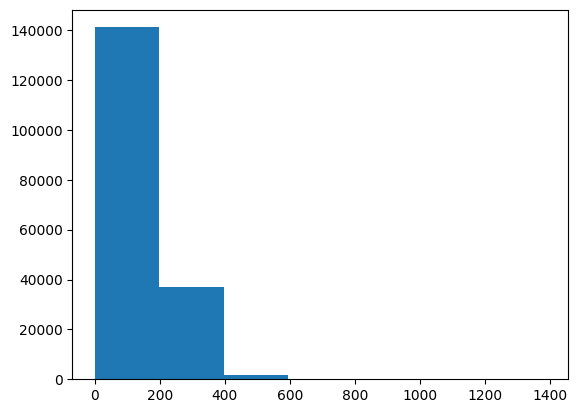

In [78]:
# Check the distribution

import matplotlib.pyplot as plt

plt.hist(chars_lens, bins=7);

In [79]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len


290

In [80]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
#random.choice(train_sentences)
len(alphabet)

68

In [81]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV out of vocab '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    #standardize="lower_and_strip_punctuation",
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [82]:
# Adapt

char_vectorizer.adapt(train_chars)

In [83]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [84]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")


Charified text:
 w i t h i n   @   m o n t h s   a f t e r   r a n d o m i z a t i o n   @   p a t i e n t s   e x p e r i e n c e d   a   r e j e c t i o n   e p i s o d e   :   m m f / p r e d   (   @   %   )   ,   m m f / c s a   (   @   %   )   a n d   m m f / c s a / p r e d   (   @   %   )   (   p   <   @   )   .

Length of random_train_chars: 118

Vectorized chars: 
 [[20  4  3 13  4  6 15  7  6  3 13  9  5 17  3  2  8  8  5  6 10  7 15  4
  25  5  3  4  7  6 14  5  3  4  2  6  3  9  2 24 14  2  8  4  2  6 11  2
  10  5  8  2 27  2 11  3  4  7  6  2 14  4  9  7 10  2 15 15 17 14  8  2
  10 15 15 17 11  9  5  5  6 10 15 15 17 11  9  5 14  8  2 10 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

In [85]:
# Creating a character level embedding


char_embed = layers.Embedding(input_dim=len(char_vocab), # size of the vocabulary ,
                              output_dim=25,  # each character gets embedded of the 25 size feature vector )
                              mask_zero=True,
                              name="char_embed")


In [86]:
# test

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"CHaracter embedding shape: {char_embed_example.shape}")

Charified text:
 w i t h i n   @   m o n t h s   a f t e r   r a n d o m i z a t i o n   @   p a t i e n t s   e x p e r i e n c e d   a   r e j e c t i o n   e p i s o d e   :   m m f / p r e d   (   @   %   )   ,   m m f / c s a   (   @   %   )   a n d   m m f / c s a / p r e d   (   @   %   )   (   p   <   @   )   .

Embeded chars (after vectorization and embedding):
 [[[-0.03548228 -0.0226351  -0.01205554 ...  0.03955518 -0.03510093
    0.01995726]
  [ 0.04301849  0.0136787   0.02629968 ...  0.03210667 -0.02056208
    0.04265252]
  [-0.04682571  0.01250232 -0.00650245 ... -0.02357963 -0.00612848
    0.0084658 ]
  ...
  [-0.01548196  0.01907105 -0.02290751 ...  0.04301334 -0.01741266
    0.03302756]
  [-0.01548196  0.01907105 -0.02290751 ...  0.04301334 -0.01741266
    0.03302756]
  [-0.01548196  0.01907105 -0.02290751 ...  0.04301334 -0.01741266
    0.03302756]]]
CHaracter embedding shape: (1, 290, 25)


In [87]:
len(random_train_chars)

303

In [88]:
## BUildding a Conv1D to fit on character embedding




inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddinngs = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddinngs)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [89]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [90]:
## Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [91]:
# Fit a model on chars only

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 26ms/step - loss: 1.2580 - accuracy: 0.4869 - val_loss: 1.0287 - val_accuracy: 0.5848
Epoch 2/3
562/562 [==============================] - 16s 29ms/step - loss: 0.9956 - accuracy: 0.6019 - val_loss: 0.9232 - val_accuracy: 0.6333
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.9173 - accuracy: 0.6391 - val_loss: 0.8542 - val_accuracy: 0.6742


In [92]:


model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[0.19184606, 0.49635932, 0.02792632, 0.23613323, 0.04773488],
       [0.13258007, 0.5672404 , 0.04192081, 0.20978662, 0.04847206],
       [0.08454981, 0.25361362, 0.09940337, 0.44459027, 0.11784286],
       ...,
       [0.00777304, 0.01372864, 0.16657372, 0.00781292, 0.80411166],
       [0.03185636, 0.14274193, 0.4494441 , 0.11222494, 0.2637327 ],
       [0.4384353 , 0.35132283, 0.12143238, 0.04650822, 0.04230137]],
      dtype=float32)

In [93]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [94]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 66.02674433999735,
 'precision': 0.65715341551297,
 'recall': 0.6602674433999736,
 'f1': 0.6561972597128962}

In [95]:
# Model 4: model 2(Pretrained token embeddings) + model 3(character embeddings )

#1. Create a token-level model (similar to model_1)
#2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
#3. Combine (using layers.Concatenate) the outputs of 1 and 2
#4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
#5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [96]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                           char_model.output])


# 4. Create output layers - adding in Dropout, discussed in in section 4.2

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")





In [97]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

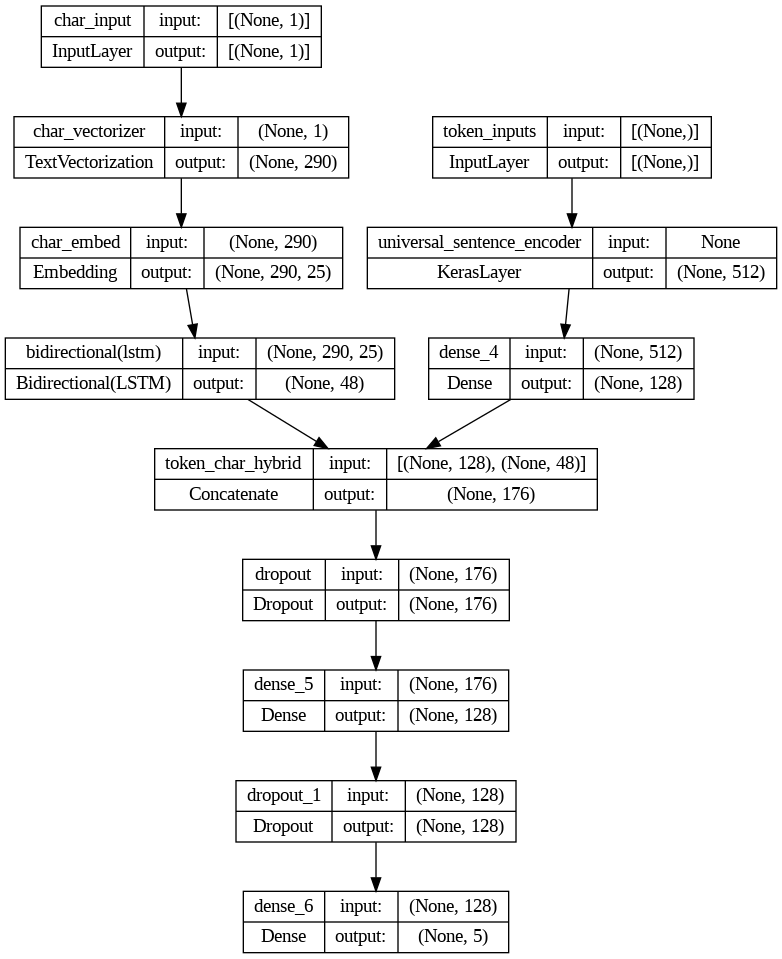

In [98]:
# PLot hybrid token andcharacter model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [99]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
### Combining token and character data into dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [101]:
### Combining token and character data into dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [102]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [103]:

history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 295s 506ms/step - loss: 0.9835 - accuracy: 0.6093 - val_loss: 0.7956 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 231s 411ms/step - loss: 0.8061 - accuracy: 0.6874 - val_loss: 0.7247 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 265s 470ms/step - loss: 0.7747 - accuracy: 0.7055 - val_loss: 0.6955 - val_accuracy: 0.7394


In [104]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)


945/945 [==============================] - 97s 103ms/step - loss: 0.6958 - accuracy: 0.7340


[0.6958315968513489, 0.7340461015701294]

In [105]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 94s 95ms/step


array([[4.7457340e-01, 3.0687690e-01, 2.3140640e-03, 2.1072370e-01,
        5.5118510e-03],
       [2.8592604e-01, 5.5774945e-01, 3.3688520e-03, 1.5029599e-01,
        2.6595758e-03],
       [2.8531244e-01, 1.4792277e-01, 5.7624195e-02, 4.7306606e-01,
        3.6074530e-02],
       ...,
       [4.2924759e-04, 1.0932465e-02, 8.5973650e-02, 1.9106583e-04,
        9.0247357e-01],
       [5.3812624e-03, 5.8355726e-02, 2.1241321e-01, 2.1355371e-03,
        7.2171432e-01],
       [2.7732676e-01, 4.1682649e-01, 2.3946181e-01, 2.6193656e-02,
        4.0191337e-02]], dtype=float32)

In [106]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [107]:
#
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

model_4_results

{'accuracy': 73.40460744075202,
 'precision': 0.7346859359890894,
 'recall': 0.7340460744075202,
 'f1': 0.7311732538794827}

In [108]:
# Model 5: Transfer learning with Pretrained token embeddings + character embeddings + positional embeddings

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [109]:
# Engineering features need to be available at test time
# Line numbers and total times are availble


### Create positional embedings
# distribution total lines

train_df["line_number"].value_counts()


,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

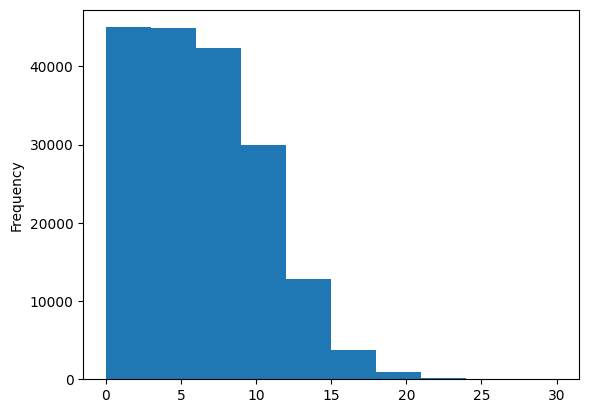

In [110]:
train_df.line_number.plot.hist()

In [111]:
# Use tf to create one hot encoded tensor

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [112]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

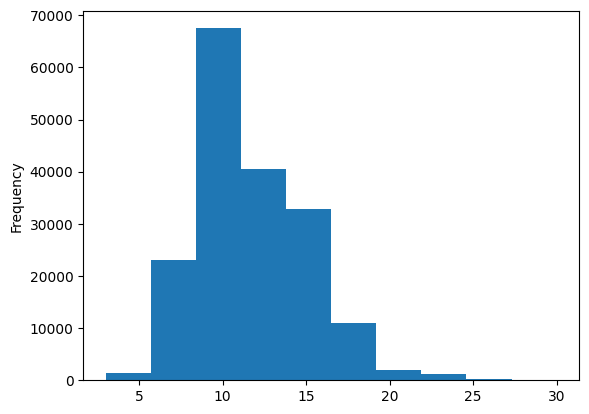

In [113]:
train_df.total_lines.plot.hist()

In [114]:
# Check the coverage of total lines value of 20

np.percentile(train_df.total_lines, 98)

20.0

In [115]:
# Use TF to create one hot encoded tenssor of our total lines features

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [116]:
### Building a tribrid embedding model


# 1.  Create a token-level model (similar to model_1)
# 2.  Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
# 3.  Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
# 4.  Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
# 5.  Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
# 6.  Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
# 7.  Create an output layer to accept the tribrid embedding and output predicted label probabilities
# 8.  Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model



In [117]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                             outputs=char_bi_lstm)


# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)


# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
# dense layer 32 units & relu activation
y = layers.Dense(32, activation="relu")(total_lines_inputs)
# combine inputs & dense layer into model
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. combine 3 4 5

tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])


# 7. Create output layer

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input], outputs=output_layer)




In [118]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

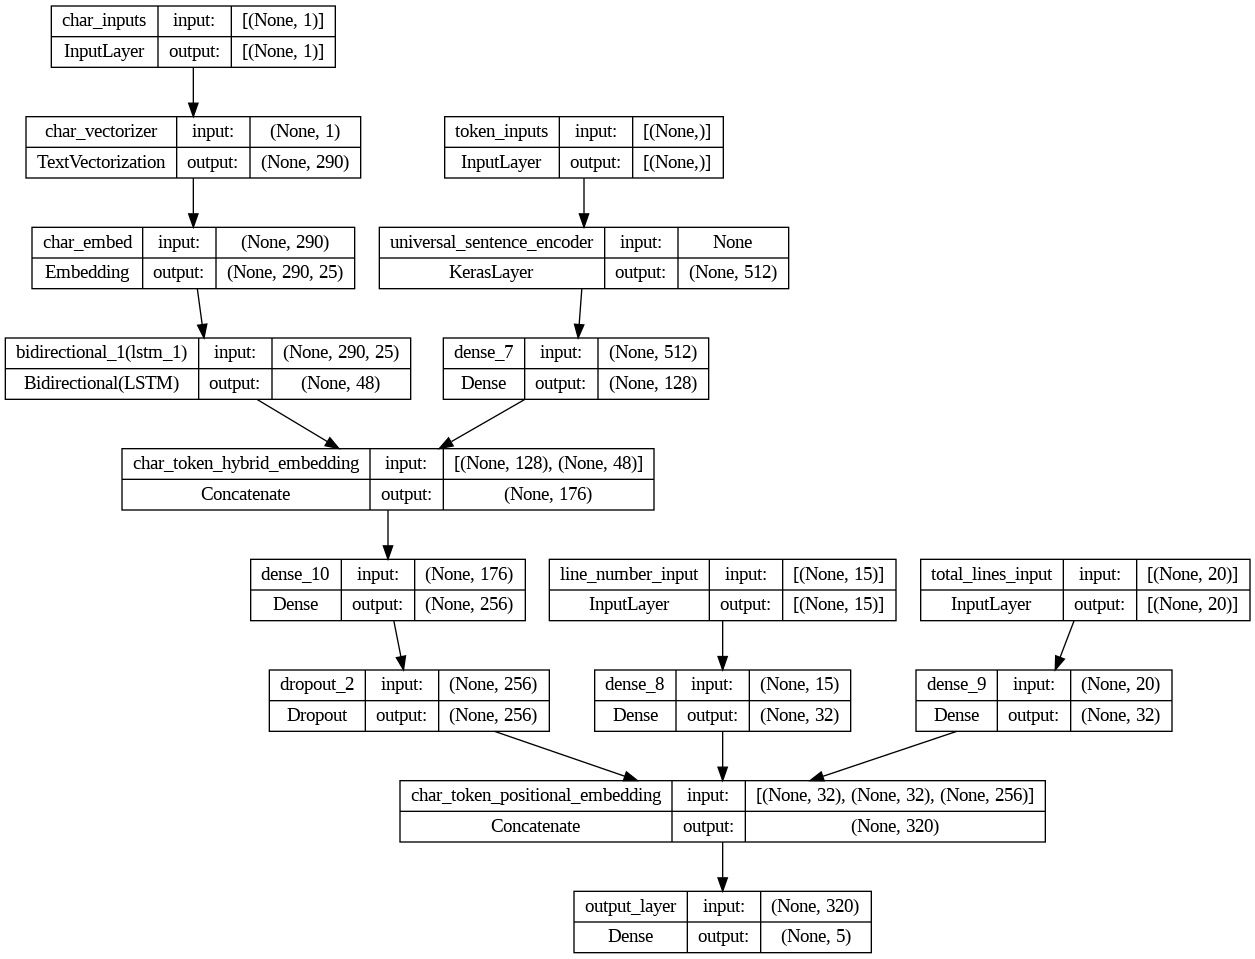

In [119]:
# Plot model_5 to explore it visually ...

from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [120]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevend overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [121]:
# For example, instead of having an output prediction of:
# [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
# It's predictions will get smoothed to be something like:
# [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.


In [122]:
# Create tribrid embddings datesets using tf.data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# Do the same to val

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


#


In [123]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [124]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 257s 434ms/step - loss: 1.0931 - accuracy: 0.7259 - val_loss: 0.9852 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 251s 446ms/step - loss: 0.9698 - accuracy: 0.8162 - val_loss: 0.9516 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 219s 389ms/step - loss: 0.9509 - accuracy: 0.8234 - val_loss: 0.9391 - val_accuracy: 0.8271


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

  7/945 [..............................] - ETA: 1:05

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results

In [ ]:
model_4_results

In [130]:
## Compare model results

# Combine model reults into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.607838,0.783251,0.786078,0.783538
model_2_pretrained_token_embedding,71.339203,0.713036,0.713392,0.710576
model_3_custom_char_embedding,66.026744,0.657153,0.660267,0.656197
model_4_hybrid_char_token_embedding,73.404607,0.734686,0.734046,0.731173
model_5_pos_char_token_embedding,83.268238,0.832156,0.832682,0.831543


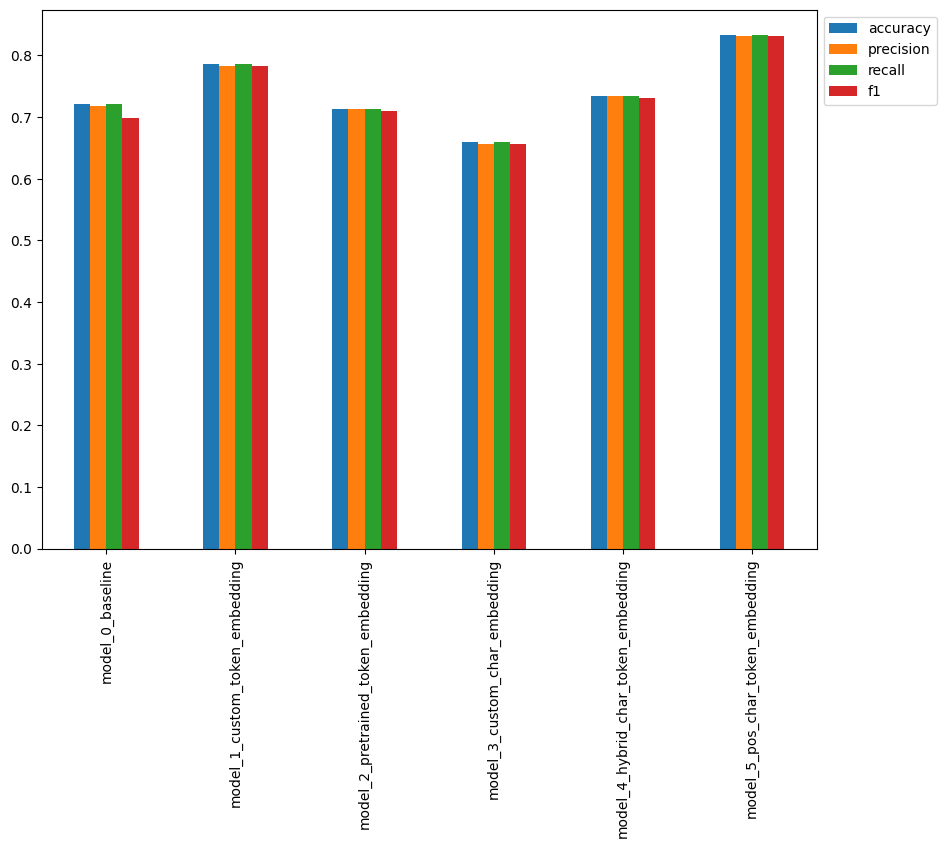

In [131]:
# Reduce the accuracy to same scale as other metrics

all_model_results["accuracy"] = all_model_results["accuracy"]/ 100

all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


<Axes: >

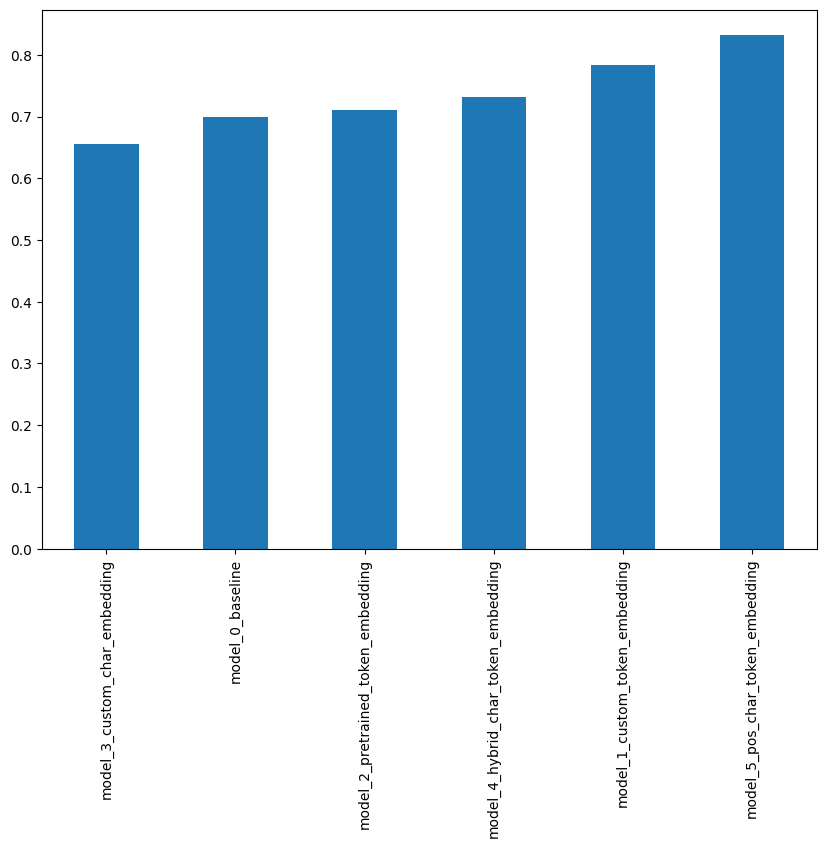

In [132]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

In [133]:
# Save and load model (the best performing model )

model_5.save("skimlit_tribrid_model")


In [134]:
# Load in best performing model

loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [135]:
# Make some predictions

model_5_results

{'accuracy': 83.26823778631007,
 'precision': 0.8321556785562826,
 'recall': 0.8326823778631007,
 'f1': 0.8315428097231506}

In [136]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 84s 84ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [149]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds )


In [142]:
loaded_model_results

{'accuracy': 83.26823778631007,
 'precision': 0.8321556785562826,
 'recall': 0.8326823778631007,
 'f1': 0.8315428097231506}

In [139]:
assert model_5_results == loaded_model_results

In [140]:
## Download and load in a pretrained model from Google Storage

import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [141]:

!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model


--2024-12-09 08:42:44--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 74.125.204.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  16.5MB/s    in 47s     

2024-12-09 08:43:32 (19.6 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [148]:
# Evaluate the loaded Google Storage model

# loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

# loaded_gs_model.evaluate(val_char_token_pos_dataset)

## Your challanges :
# Turn the test datasamples into a tf.data Dataset (fast loading ) and then
# evaluate (make predictions ) the best performing model on test samples .


# 2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability ).
# 3. Make example predictions (on RCT abstracts from the wild),
# you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/
# find and use our model to predict on 3 - 4 different abstracts from the wild.
# Some examples :
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
# 4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09 )



In [ ]:

abstract_lines = "asd fff ggg ggg"
x = abstract_lines.splitlines()
x

['asd fff ggg ggg']

In [ ]:
abstract_line = "32243\tvvgv"
abstract_line.split("\t")

['32243', 'vvgv']

In [ ]:
x = 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'
x.isspace()
y = 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'

False

In [ ]:
z = x + y

In [ ]:
c = z.splitlines()
c[0]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'